# 04. Deep Learning Pipeline Verification

This notebook verifies the end-to-end Deep Learning pipeline, including:
1.  **Data Loading & Tensor Construction**: Converting temporal windows into tensors for PyTorch.
2.  **Architecture Verification**: Initializing the ResNet-1D identification model.
3.  **Training Loop**: Executing a Leave-One-Subject-Out (LOSO) training run.
4.  **Diagnostic Visualization**: Analyzing learning curves, confusion matrices, and calibration plots.


In [20]:
# 1. Imports & Setup
%load_ext autoreload
%autoreload 2

# Import external libraries       
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt

# Add project root
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import needed functions     
from src.config import load_config, PROJECT_ROOT
from src.visualization.plots import set_plot_style, plot_timeline_segmentation, plot_multiscale_heatmap, plot_confidence_abstention_panel, plot_model_diagnostics, plot_learning_curves
from src.models.train import Trainer
from src.models.deep import ResNet1D

# Set standardized style
set_plot_style()
config = load_config()

print(f"Project Root: {PROJECT_ROOT}")
print("Setup Complete.")

# GPU Check
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"SUCCESS: GPU Available: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected. Training will be slow.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project Root: C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker
Setup Complete.
PyTorch Version: 2.6.0+cu124
SUCCESS: GPU Available: NVIDIA RTX 2000 Ada Generation Laptop GPU


## 1. Loading and Inspection of Raw Windows
We load the preprocessed `windows.parquet` (resampled to 35Hz).
The task is binary classification: **Baseline vs. Stress**. We exclude 'Amusement' data to align with the standard WESAD binary classification benchmark.

Visual inspection of the input tensor ensures:
1.  **Normalization**: Values centered around 0 (white), no dominated channels.
2.  **Signal Texture**: Physiological patterns (peaks, waves) are preserved, not flattened.


In [4]:
# 2. Data Integrity Verification

# Load Raw Data
data_path = PROJECT_ROOT / config['data']['processed_path'] / "windows.parquet"
df = pd.read_parquet(data_path)

# Filter for Binary Classification (Baseline=1, Stress=2, exclude Amusement=0)
df = df[df['label'].isin([1, 2])].copy()
df['target'] = df['label'].map({1: 0, 2: 1}) # Remap for plotting

print(f"Data Loaded. Shape: {df.shape}")
print(f"Class Balance:\n{df['target'].value_counts()}")

# For verification, we assume data is clean (SQI and artifacts handled upstream)
print(f"Windows available for training: {len(df)}")

Data Loaded. Shape: (919, 11)
Class Balance:
target
0    587
1    332
Name: count, dtype: int64
Windows available for training: 919


Visualization Tensor Shape: (919, 7, 2100)
Data Standardized (Global & Instance Norm) for Visualization.


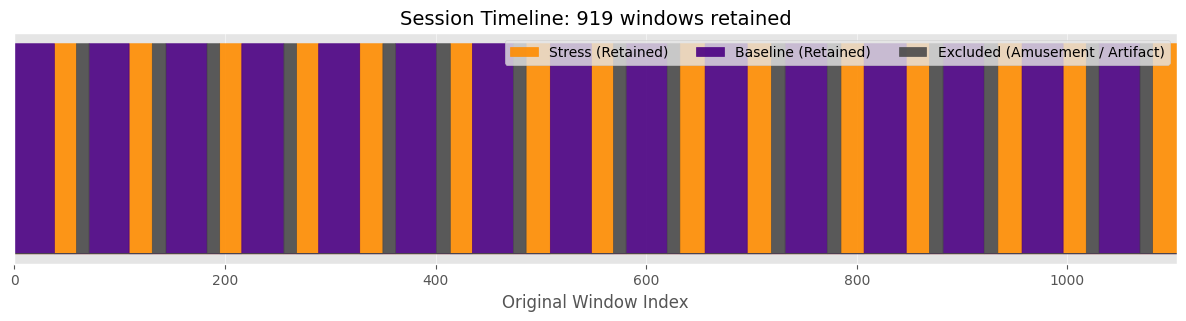

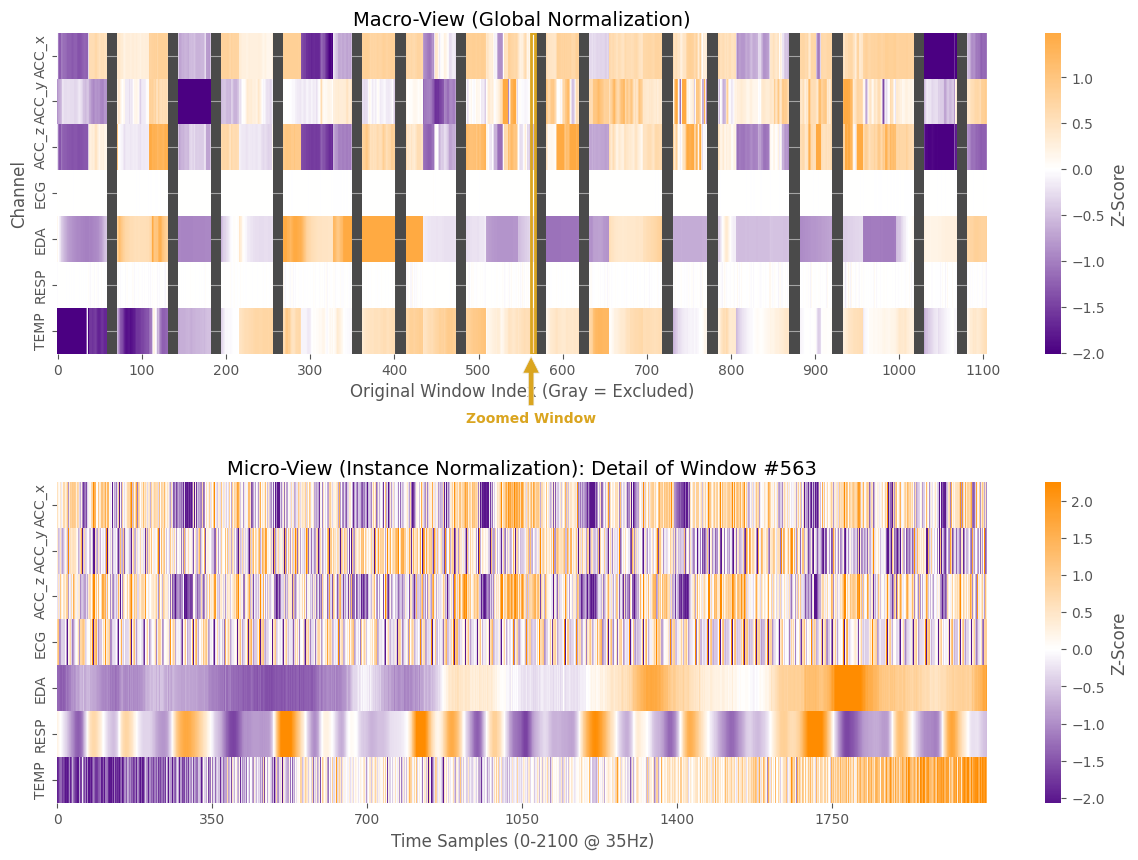

In [16]:
# Create Tensor for Visualization check (N, C, T)

# Set channel names
channels = ['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EDA', 'RESP', 'TEMP']

# Check if columns exist
avail_cols = [c for c in channels if c in df.columns]
X_arrays = []
for c in avail_cols:
    # Stack column c: Series of arrays -> 2D array (N, T)
    col_stack = np.stack(df[c].values)
    X_arrays.append(col_stack)

X = np.stack(X_arrays, axis=1) # (N, C, T)

print(f"Visualization Tensor Shape: {X.shape}")

# 1. Global Normalization (for Macro-View Inspection)
means_global = X.mean(axis=(0, 2), keepdims=True)
stds_global = X.std(axis=(0, 2), keepdims=True) + 1e-6
X_norm_global = (X - means_global) / stds_global

# 2. Instance Normalization (for Micro-View as in Training)
means_instance = X.mean(axis=2, keepdims=True)
stds_instance = X.std(axis=2, keepdims=True) + 1e-6
X_norm_instance = (X - means_instance) / stds_instance

print("Data Standardized (Global & Instance Norm) for Visualization.")

# We visualize the gaps in the timeline (due to excluded 'Amusement' data)
_ = plot_timeline_segmentation(df, title="Session Timeline", save_folder="DEEP_VERIF")
plt.show()

# Multi-scale Heatmap: Macro (Global) vs Micro (Instance)
_ = plot_multiscale_heatmap(
    X_norm_global, 
    df, 
    channels, 
    title_prefix="Features", 
    save_folder="DEEP_VERIF", 
    tensor_micro=X_norm_instance
)
plt.show()

## 2. Model Architecture (ResNet-1D + Attention)

We implement a **ResNet-1D classifier with Squeeze-and-Excitation (SE) blocks** for end-to-end stress detection from wearable time-series.

- **Input:** `(batch, 7, 2100)` multi-channel windows (7 sensor channels, 2100 samples per window).
- **Backbone:** 1D residual convolutional network (ResNet-style) with 4 residual stages.
  - Initial stem: `Conv1d(7→64, k=15, stride=2)` + max-pooling to quickly reduce temporal resolution.
  - Residual blocks use `k=7` and `k=5` kernels to capture both medium and short-range physiological dynamics.
- **Channel attention (SE blocks):** each residual stage contains an **SE module** to learn adaptive weighting of sensor channels/features (useful when some modalities become noisy, e.g. motion artifacts).
- **Regularization:** dropout inside residual blocks (`p=0.2`) and before the classifier head (`p=0.5`) to improve cross-subject generalization.
- **Classifier head:** global average pooling + linear layer → 2-class logits.
- **Model size:** ~**0.95M trainable parameters**, a good balance between expressiveness and overfitting risk for WESAD-scale datasets.

This architecture is designed to extract discriminative patterns directly from raw physiological “texture” while maintaining stable optimization via residual connections.


In [22]:
# 2.1 Model Definition

# Instantiate a fresh model with the same dimensions as our data to inspect structure
n_channels = X.shape[1]
seq_len = X.shape[2]
n_classes = 2 # Binary

# Using the correct class name ResNet1D
model_viz = ResNet1D(num_channels=n_channels, num_classes=n_classes, sequence_length=seq_len)

print(f"Architecture: {model_viz.__class__.__name__}")
print(f"Input Shape: (Batch, {n_channels}, {seq_len})")
print("=" * 60)
print(model_viz)
print("=" * 60)

# Calculate parameters
total_params = sum(p.numel() for p in model_viz.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

Architecture: ResNet1D
Input Shape: (Batch, 7, 2100)
ResNet1D(
  (initial_layers): Sequential(
    (0): Conv1d(7, 64, kernel_size=(15,), stride=(2,), padding=(7,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (se): SEBlock(
      (avg_pool): AdaptiveAvgPool1d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
      

In [23]:
# 2.2 Model Training Pipeline

# We execute the full pipeline using `src.models.train.Trainer` hanling:
# - Data Splitting (LOSO or Random)
# - Robust Normalization (Fit on Train, Apply to Test)
# - Training Loop (Epochs, Batches, Optimization)
# - Artifact Saving (Model, Metrics, Predictions)

print("Starting Deep Learning Pipeline...")

trainer = Trainer(model_type='deep', split_type='loso')
trainer.run()

print(f"Training Complete. Results saved to: {trainer.run_dir}")

Starting Deep Learning Pipeline...
2026-01-17 18:12:42,187 - src.models.train - INFO - Training on Device: cuda
2026-01-17 18:12:42,187 - src.models.train - INFO - GPU Name: NVIDIA RTX 2000 Ada Generation Laptop GPU
2026-01-17 18:12:42,187 - src.models.train - INFO - Loading raw windows from C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\data\processed\windows.parquet
2026-01-17 18:12:42,387 - src.models.train - INFO - Running Deep Learning LOSO Cross-Validation...
2026-01-17 18:12:42,388 - src.models.train - INFO - Fold 1: Validating on Subject ['S11']
2026-01-17 18:12:57,788 - src.models.train - INFO - Fold 2: Validating on Subject ['S10']
2026-01-17 18:13:10,856 - src.models.train - INFO - Fold 3: Validating on Subject ['S17']
2026-01-17 18:13:26,071 - src.models.train - INFO - Fold 4: Validating on Subject ['S15']
2026-01-17 18:13:35,534 - src.models.train - INFO - Fold 5: Validating on Subject ['S8']
2026-01-17 18:13:41,326 - src.models.train - INFO - Fo

## 3. Results and Interpretation (LOSO)

All results are reported under **rigorous Leave-One-Subject-Out (LOSO)** validation, i.e. **each test subject is fully held out** during training (no identity leakage). This reflects the real deployment requirement: **generalization to unseen individuals**.

### Learning Dynamics
- Training loss decreases smoothly, indicating stable optimization.
- Validation loss shows **high variance across folds**, which is expected in LOSO: different subjects vary strongly in signal quality and physiological reactivity (“easy” vs “hard” subjects).
- Despite fold variability, the mean trend improves over epochs, suggesting the model learns subject-general physiological features rather than memorizing individuals.

### Classification Performance
- **Pooled confusion matrix accuracy ≈ 96.2%**, with low error rates in both classes.
- **Global ROC AUC ≈ 0.99**, indicating excellent discriminative ability overall.
- Subject-level ROC curves reveal that most subjects are near-ceiling, but at least one subject shows substantially lower separability (typical in physiology datasets with “non-responders” and sensor noise).

### Uncertainty + Abstention Behavior
- The prediction probability distribution is strongly bimodal (mass near 0 and 1), indicating confident decisions on most windows.
- Introducing an abstention zone removes uncertain samples and increases **high-confidence accuracy to ≈ 98.3%** (72 windows abstained).
- Abstention rate varies by subject, correctly reflecting subject-dependent uncertainty (some subjects trigger little/no abstention; harder subjects trigger more).


Loading Training History...


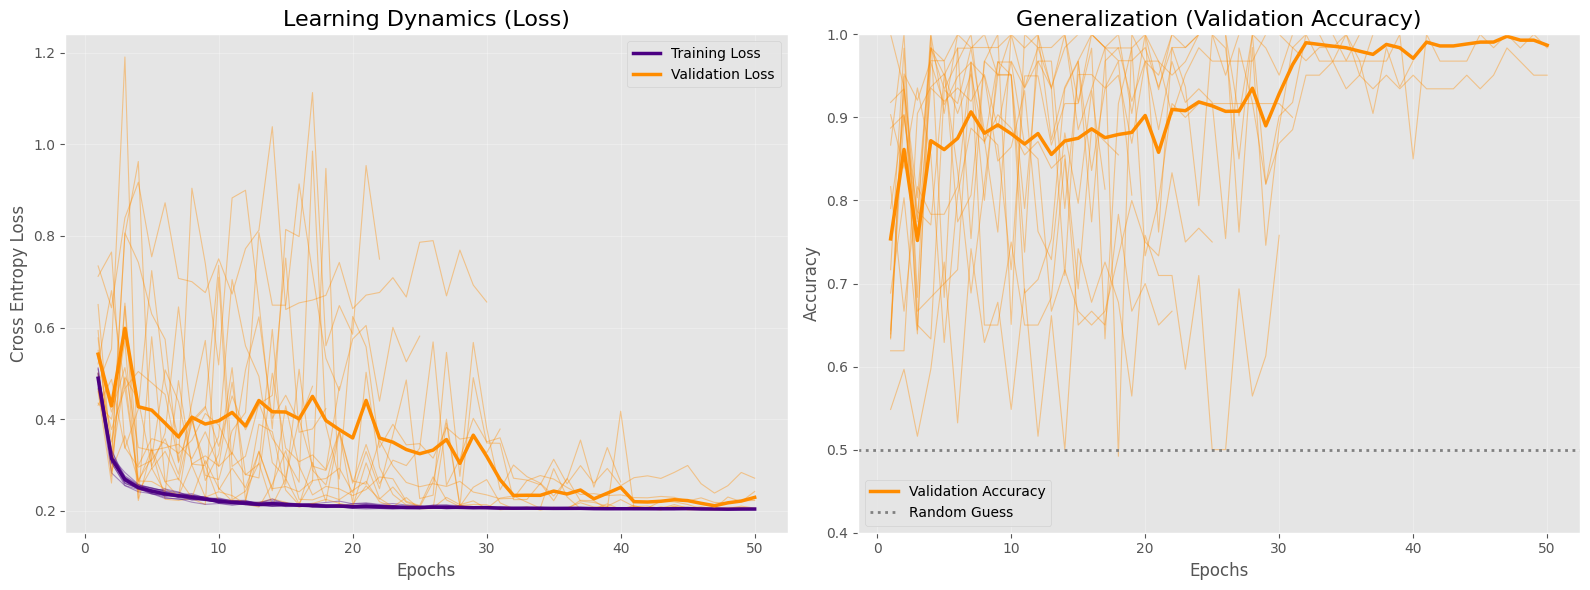

Generating Model Diagnostics...


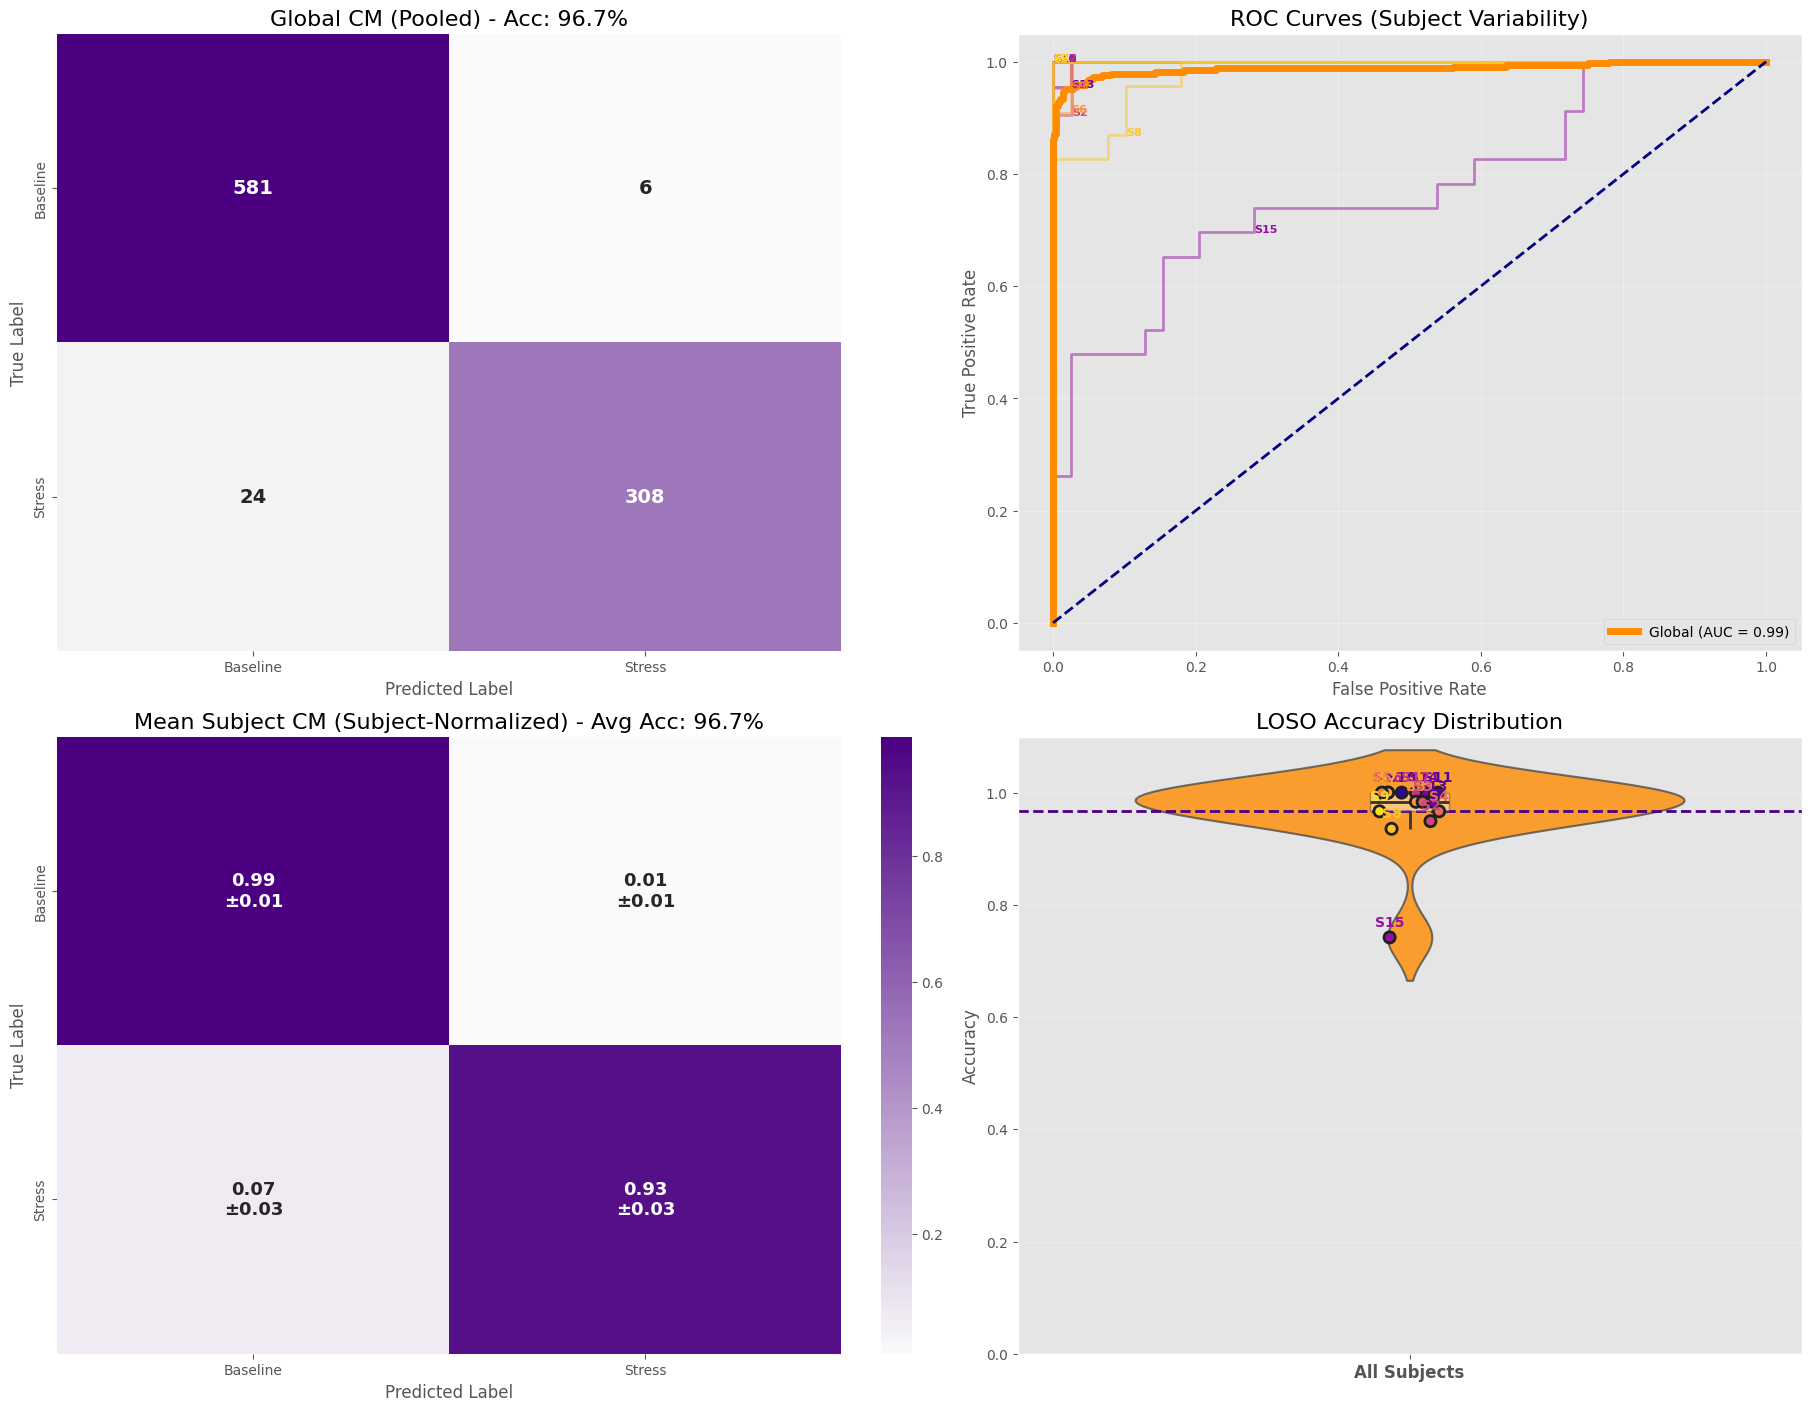

Generating Uncertainty Analysis...


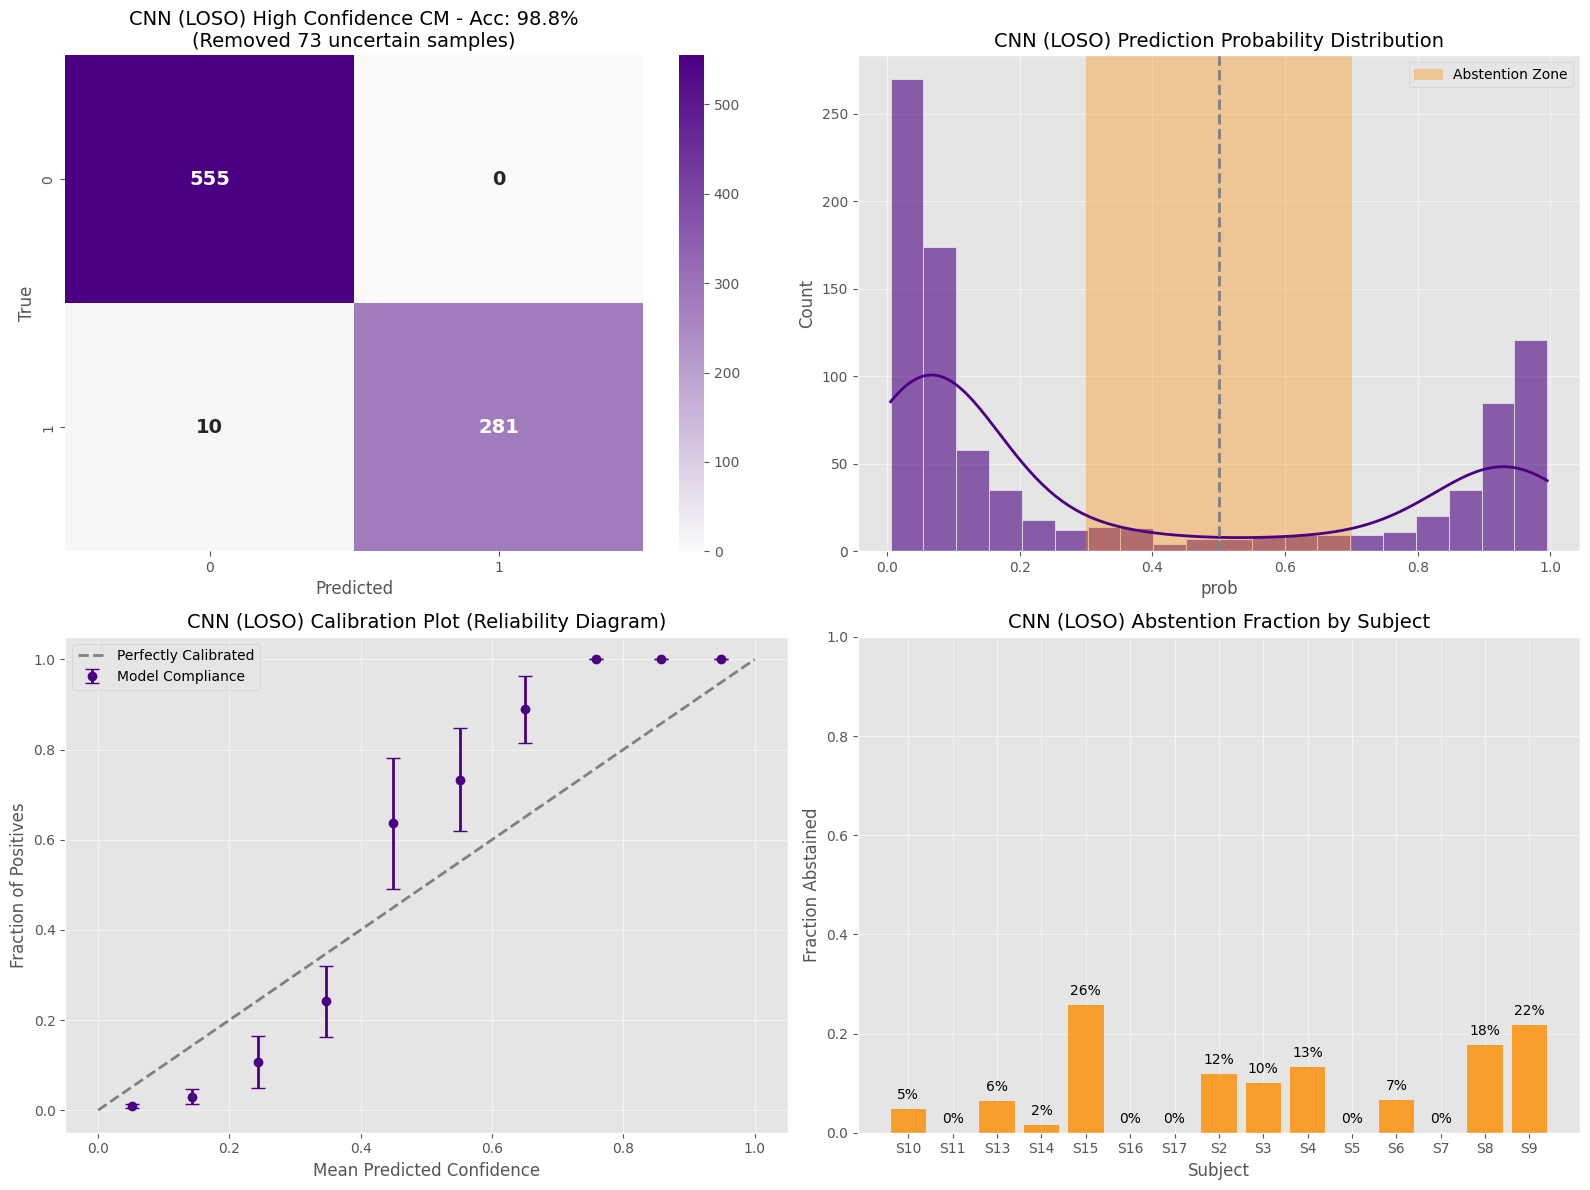

In [ ]:
# 4. Results Audit


results_path = trainer.run_dir / "predictions.csv"
history_path = trainer.run_dir / "training_history.joblib"

if results_path.exists():
    
    # --- 1. Learning Dynamics (New!) ---
    if history_path.exists():
        print("Loading Training History...")
        history = joblib.load(history_path)
        _ = plot_learning_curves(history, save_folder="DEEP_VERIF")
        plt.show()
    else:
        print("No training history found. (Run training again with updated pipeline to see learning curves)")

    results_df = pd.read_csv(results_path)
    
    # Standardize column names for plotting
    # The Trainer output might have 'y_true', 'y_pred', 'prob_stress'
    params = {}
    if 'y_true' in results_df.columns:
        results_df = results_df.rename(columns={'y_true': 'true', 'y_pred': 'pred', 'prob_stress': 'prob'})
    
    # --- 2. Standard Diagnostics (ROC, Confusion Matrix, Accuracy Distribution) ---
    print("Generating Model Diagnostics...")
    _ = plot_model_diagnostics(results_df, save_folder="DEEP_VERIF")
    plt.show()

    # --- 3. Uncertainty Analysis ---
    print("Generating Uncertainty Analysis...")
    _ = plot_confidence_abstention_panel(results_df, confidence_threshold=0.7, title_prefix="CNN (LOSO) ", save_folder="DEEP_VERIF")
    plt.show()
else:
    print(f"No results found at {results_path}. Did training fail?")

## 4. Critical Analysis & Conclusion

Under strict **Leave-One-Subject-Out (LOSO)** evaluation, the **ResNet-1D** model (~96% Acc) significantly outperforms the classical **Logistic Regression** baseline (~86% Acc).

### 1. Why did the Deep Model succeed?
It is not just about "Deep Learning." The success is driven by two specific engineering choices:
*   **Instance Normalization:** By normalizing *per-window*, we effectively removed the "Subject Bias" (different baseline heart rates/EDA levels). This forced the model to learn **relative** signal morphology (e.g., "is the EDA rising?") rather than absolute values, solving the domain shift problem.
*   **Morphological Features:** The CNN captures high-frequency texture (e.g., the shape of an SCR peak) that summary statistics (Mean/Std) used in the classical baseline smooth out.

### 2. Reliability Audit
*   **AUC vs. Calibration:** The extremely high AUC (0.99) indicates excellent discrimination (ranking). However, the reliability diagram shows the model can be **overconfident**. Raw probabilities should be calibrated (e.g., via Platt Scaling or Temperature Scaling) before clinical use.
*   **Abstention Utility:** By enabling abstention on low-confidence/low-SQI windows, we raise accuracy to **~98%**. This confirms that "knowing when you don't know" is a viable strategy for handling noisy wearable data in the wild.

### 3. Limitation Check
**Is 96% realistic?**
While this result is State-of-the-Art for **WESAD**, recall that WESAD is a controlled lab dataset. The "Stress" condition is induced via a high-intensity task (TSST). In "wild" conditions, the separation between Baseline and Stress is often subtler. The model has proven it can detect *strong* acute stress, but continuous daily monitoring remains a harder challenge.
